# Initial Bert Model
### **Genre Label: 8**
### **Data: Unbalance**

In [ ]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Loading the Dataset and Encoding the Text

In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/train_df.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/validation_df.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/test_df.pkl')

In [ ]:
# getting the training, validation, and test text
train_text = train_df['lyrics'].tolist()
validation_text = validation_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

# getting the training, validation, and test label
train_label = train_df['mapped_genres'].tolist()
validation_label = validation_df['mapped_genres'].tolist()
test_label = test_df['mapped_genres'].tolist()

In [ ]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
validation_text = [preprocess_text(text) for text in validation_text]
test_text = [preprocess_text(text) for text in test_text]

In [ ]:
# encoding the labels
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
validation_label = encode_label.fit_transform(validation_label)
test_label = encode_label.fit_transform(test_label)

In [ ]:
# initializeing TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features= 10000)

# fit and transform the text
X_train = tfidf_vectorizer.fit_transform(train_text)
X_val = tfidf_vectorizer.transform(validation_text)
X_test = tfidf_vectorizer.transform(test_text)

In [ ]:
# scaling tf-idf feature
scaler = StandardScaler(with_mean = False)
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

# Bert Model

In [ ]:
from transformers import BertTokenizer, TFBertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
word_len = [len(w.split()) for w in train_text]

sum(word_len) / len(word_len)

248.5789916798732

In [ ]:
MAX_SEQUENCE_LENGTH = 250

In [ ]:
#@title BERT Tokenization of training and val data

bert_train_tokenized = bert_tokenizer(train_text,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_label)

NameError: name 'train_text' is not defined

In [ ]:
bert_val_tokenized = bert_tokenizer(validation_text,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
                     bert_val_tokenized.token_type_ids,
                     bert_val_tokenized.attention_mask]
bert_val_labels = np.array(validation_label)

In [ ]:
bert_train_tokenized.input_ids[0]

<tf.Tensor: shape=(250,), dtype=int32, numpy=
array([  101,  5398,  1112,  1128,  1338,  1107,  1155,  1103,  8839,
        1355,  1283,  1220,  3535,  1115,  1128,   112,  1231,  3258,
        7911,  6174,  1128,  1817,  1173,  1435,  1171,  1111,  1167,
        1109, 16024,  7311,  1106,  1712,  1366,  1155,  8264,  1262,
         146,  1431,  1138,  1227,  1249,  1770,  1112,  1128,  1338,
        1107,  1103, 13965,  1122,  1355,  1283,   146,  3535,  1184,
        1128,  4307,  1106,  1917,  1195,  2910,  1105,  1167,  1262,
        1103, 16024,  7311,  1106,  1712,  1366,  1155,  8264,  1262,
         146,  1431,  1138,  1227,  1135,  1178,  2274,  1141,  2549,
        1104,  1240, 14131,  1106,  1243,  1228,  1706,  3277,  1412,
        1282,  1313,  1114,  1128,  1253,  1103,  1269,  1461,  1249,
        1770,  1112,  1128,  1338,  1107,  2181,  1165,   146,  2059,
        1195,  1241,  7573,  1736,  1262,  1103, 16024,  7311,  1106,
        1712,  1366,  1155,  8264,  1262,   

In [ ]:
def create_bert_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(8, activation='softmax',name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_model_0 = create_bert_model(bert_model)
bert_model_0.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 250)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                      

In [ ]:
bert_model_0_history = bert_model_0.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_val_inputs, bert_val_labels),
    batch_size=8,
    epochs=2
)

Epoch 1/2
5048/5048 [==============================] - 2339s 456ms/step - loss: 1.5992 - accuracy: 0.3932 - val_loss: 1.4754 - val_accuracy: 0.4509
Epoch 2/2
5048/5048 [==============================] - 2295s 455ms/step - loss: 1.4168 - accuracy: 0.4710 - val_loss: 1.4748 - val_accuracy: 0.4216


In [ ]:
# evaluate the model based on the validation set

val_predictions = bert_model_0.predict(bert_val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(bert_val_labels, val_predictions, target_names=encode_label.classes_))

158/158 [==============================] - 94s 570ms/step
                precision    recall  f1-score   support

   Alternative       0.67      0.51      0.58      1186
Country & Folk       0.23      0.59      0.34       507
    Electronic       0.49      0.06      0.11       611
 Hip Hop & Rap       0.61      0.87      0.72       246
  Jazz & Blues       0.59      0.13      0.21       101
           Pop       0.50      0.50      0.50      1001
          Rock       0.33      0.41      0.36      1129
   Soul & Funk       0.36      0.02      0.04       267

      accuracy                           0.42      5048
     macro avg       0.47      0.39      0.36      5048
  weighted avg       0.47      0.42      0.40      5048



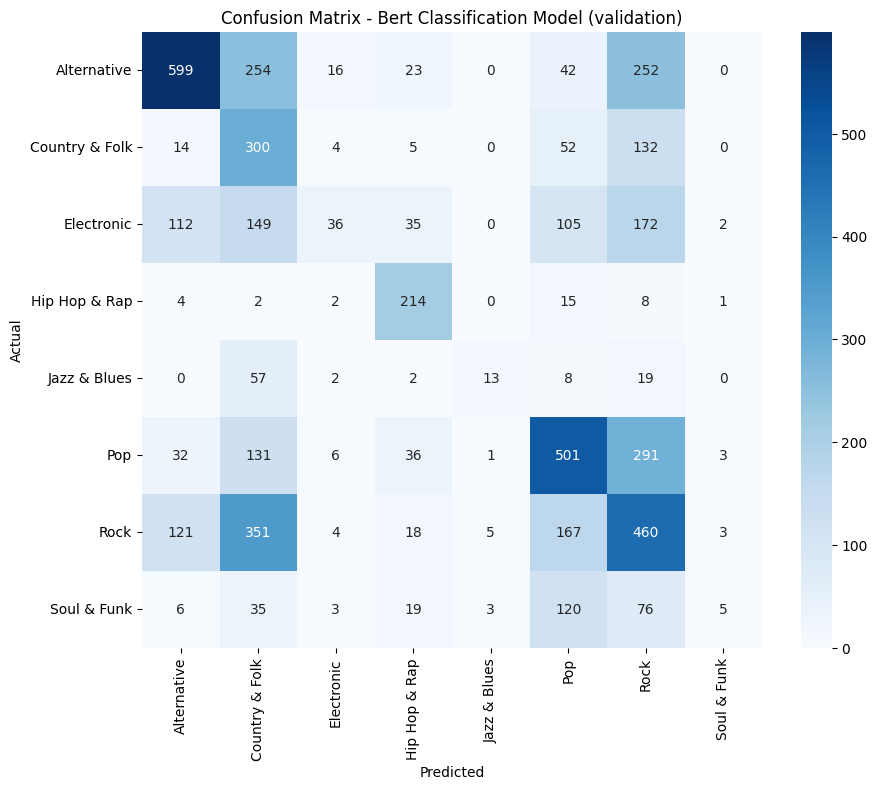

In [ ]:
conf_mat = confusion_matrix(bert_val_labels, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Bert Classification Model (validation)')
plt.show()

In [ ]:
# tokenizing the test data
bert_test_tokenized = bert_tokenizer(test_text,
                                     max_length=MAX_SEQUENCE_LENGTH,
                                     truncation=True,
                                     padding='max_length',
                                     return_tensors='tf')

bert_test_inputs = {'input_ids_layer': bert_test_tokenized.input_ids,
                    'token_type_ids_layer': bert_test_tokenized.token_type_ids,
                    'attention_mask_layer': bert_test_tokenized.attention_mask}

bert_test_labels = np.array(test_label)

In [ ]:
test_predictions = bert_model_0.predict(bert_test_inputs)
test_predictions = np.argmax(test_predictions, axis=1)

print(classification_report(bert_test_labels, test_predictions, target_names=encode_label.classes_))

158/158 [==============================] - 94s 575ms/step
                precision    recall  f1-score   support

   Alternative       0.68      0.51      0.58      1159
Country & Folk       0.23      0.59      0.33       473
    Electronic       0.63      0.08      0.15       648
 Hip Hop & Rap       0.60      0.86      0.71       243
  Jazz & Blues       0.46      0.05      0.10       113
           Pop       0.53      0.54      0.54      1046
          Rock       0.33      0.43      0.38      1111
   Soul & Funk       0.67      0.02      0.05       255

      accuracy                           0.43      5048
     macro avg       0.52      0.39      0.35      5048
  weighted avg       0.52      0.43      0.42      5048



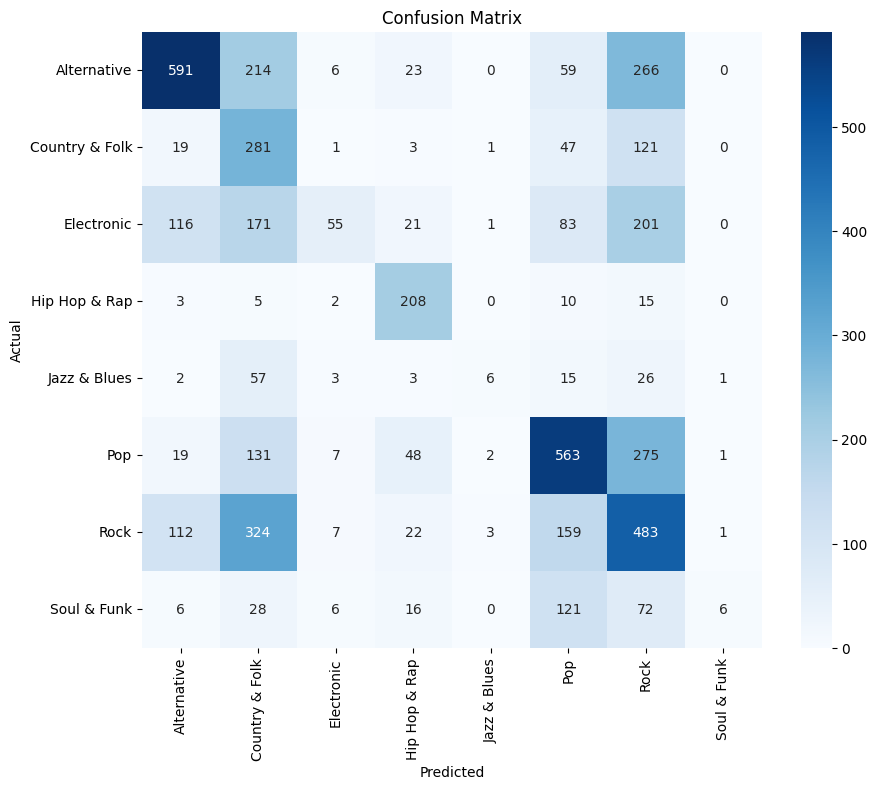

In [ ]:
conf_mat = confusion_matrix(bert_test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()